

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

### [профиль на Kaggle](https://www.kaggle.com/leoaganist)
### Team Name: Leonid_Razdobreev_42848593

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/My\ Drive/journey-springfield.zip

In [4]:
!nvidia-smi

Thu Apr 22 03:52:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [5]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import models
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [25]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f'{self.mode}  is not correct; correct modes: {DATA_MODES}')
            raise NameError
        
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        
    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
            
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [26]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

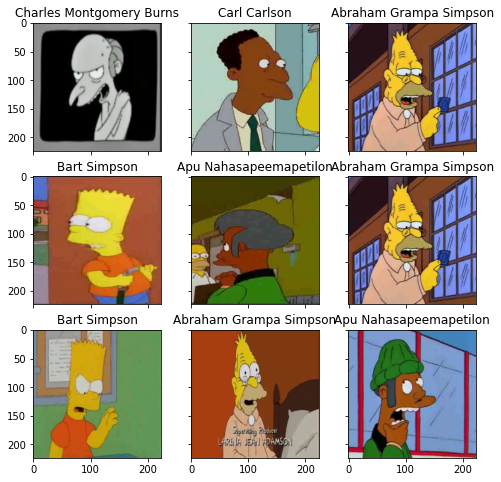

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети



In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels))

Запустим обучение сети.

In [34]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [109]:
model_resnet = models.resnet18(pretrained=True).to(DEVICE)
child_counter = 0
for child in model_resnet.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

 child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is:
ReLU(inplace=True)
 child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64

In [38]:
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = True

model_resnet.fc = nn.Sequential(nn.Linear(512,42))

In [39]:
model_resnet = model_resnet.cuda()

In [40]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=30, batch_size=128)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.7934418730834037


epoch:   3%|▎         | 1/30 [03:46<1:49:35, 226.76s/it]


Epoch 001 train_loss: 0.7934     val_loss 0.8467 train_acc 0.8018 val_acc 0.7935
loss 3.1209219296013933


epoch:   7%|▋         | 2/30 [07:29<1:45:16, 225.58s/it]


Epoch 002 train_loss: 3.1209     val_loss 3.1140 train_acc 0.1136 val_acc 0.1074
loss 3.116700739729624


epoch:  10%|█         | 3/30 [11:12<1:41:09, 224.80s/it]


Epoch 003 train_loss: 3.1167     val_loss 3.1120 train_acc 0.1073 val_acc 0.1074
loss 3.1143587294395765


epoch:  13%|█▎        | 4/30 [14:56<1:37:20, 224.65s/it]


Epoch 004 train_loss: 3.1144     val_loss 3.1056 train_acc 0.1073 val_acc 0.1074
loss 3.0801947461138015


epoch:  17%|█▋        | 5/30 [18:40<1:33:28, 224.36s/it]


Epoch 005 train_loss: 3.0802     val_loss 3.0193 train_acc 0.1110 val_acc 0.1221
loss 2.940165794095429


epoch:  20%|██        | 6/30 [22:24<1:29:41, 224.22s/it]


Epoch 006 train_loss: 2.9402     val_loss 2.6711 train_acc 0.1443 val_acc 0.2306
loss 2.4892030944869172


epoch:  23%|██▎       | 7/30 [26:08<1:25:52, 224.04s/it]


Epoch 007 train_loss: 2.4892     val_loss 1.9838 train_acc 0.2934 val_acc 0.4234
loss 1.8066458850083393


epoch:  27%|██▋       | 8/30 [29:51<1:22:08, 224.00s/it]


Epoch 008 train_loss: 1.8066     val_loss 1.2684 train_acc 0.4941 val_acc 0.6460
loss 1.248881844974899


epoch:  30%|███       | 9/30 [33:35<1:18:19, 223.80s/it]


Epoch 009 train_loss: 1.2489     val_loss 1.0896 train_acc 0.6570 val_acc 0.7149
loss 0.9639423011070498


epoch:  33%|███▎      | 10/30 [37:18<1:14:33, 223.66s/it]


Epoch 010 train_loss: 0.9639     val_loss 0.7598 train_acc 0.7284 val_acc 0.7954
loss 0.7628660667693586


epoch:  37%|███▋      | 11/30 [41:03<1:10:57, 224.10s/it]


Epoch 011 train_loss: 0.7629     val_loss 0.7217 train_acc 0.7866 val_acc 0.8045
loss 0.658649189368624


epoch:  40%|████      | 12/30 [44:46<1:07:06, 223.67s/it]


Epoch 012 train_loss: 0.6586     val_loss 0.5588 train_acc 0.8141 val_acc 0.8527
loss 0.5564091246278736


epoch:  43%|████▎     | 13/30 [48:28<1:03:14, 223.18s/it]


Epoch 013 train_loss: 0.5564     val_loss 0.4876 train_acc 0.8427 val_acc 0.8708
loss 0.48989141329005764


epoch:  47%|████▋     | 14/30 [52:11<59:29, 223.09s/it]


Epoch 014 train_loss: 0.4899     val_loss 0.4597 train_acc 0.8631 val_acc 0.8821
loss 0.4192022834167988


epoch:  50%|█████     | 15/30 [55:53<55:43, 222.88s/it]


Epoch 015 train_loss: 0.4192     val_loss 0.4963 train_acc 0.8802 val_acc 0.8743
loss 0.3698350065824704


epoch:  53%|█████▎    | 16/30 [59:36<51:58, 222.77s/it]


Epoch 016 train_loss: 0.3698     val_loss 0.4028 train_acc 0.8961 val_acc 0.8964
loss 0.35394583059591933


epoch:  57%|█████▋    | 17/30 [1:03:19<48:17, 222.92s/it]


Epoch 017 train_loss: 0.3539     val_loss 0.4285 train_acc 0.8995 val_acc 0.8842
loss 0.32025773611499425


epoch:  60%|██████    | 18/30 [1:07:03<44:38, 223.20s/it]


Epoch 018 train_loss: 0.3203     val_loss 0.3707 train_acc 0.9094 val_acc 0.9100
loss 0.27359870037832673


epoch:  63%|██████▎   | 19/30 [1:10:46<40:54, 223.14s/it]


Epoch 019 train_loss: 0.2736     val_loss 0.3961 train_acc 0.9223 val_acc 0.9026
loss 0.2588043072734853


epoch:  67%|██████▋   | 20/30 [1:14:30<37:13, 223.38s/it]


Epoch 020 train_loss: 0.2588     val_loss 0.3324 train_acc 0.9259 val_acc 0.9207
loss 0.23954423098733027


epoch:  70%|███████   | 21/30 [1:18:13<33:29, 223.25s/it]


Epoch 021 train_loss: 0.2395     val_loss 0.5080 train_acc 0.9322 val_acc 0.8794
loss 0.23045073000270322


epoch:  73%|███████▎  | 22/30 [1:21:55<29:42, 222.87s/it]


Epoch 022 train_loss: 0.2305     val_loss 0.4236 train_acc 0.9325 val_acc 0.9020
loss 0.2112337383164882


epoch:  77%|███████▋  | 23/30 [1:25:37<25:58, 222.62s/it]


Epoch 023 train_loss: 0.2112     val_loss 0.3665 train_acc 0.9406 val_acc 0.9140
loss 0.19962049380853167


epoch:  80%|████████  | 24/30 [1:29:19<22:14, 222.50s/it]


Epoch 024 train_loss: 0.1996     val_loss 0.3473 train_acc 0.9398 val_acc 0.9230
loss 0.1914048091348808


epoch:  83%|████████▎ | 25/30 [1:33:02<18:32, 222.51s/it]


Epoch 025 train_loss: 0.1914     val_loss 0.3377 train_acc 0.9420 val_acc 0.9217
loss 0.15619276244914929


epoch:  87%|████████▋ | 26/30 [1:36:44<14:50, 222.59s/it]


Epoch 026 train_loss: 0.1562     val_loss 0.3678 train_acc 0.9542 val_acc 0.9173
loss 0.14929726491768547


epoch:  90%|█████████ | 27/30 [1:40:27<11:08, 222.72s/it]


Epoch 027 train_loss: 0.1493     val_loss 0.3825 train_acc 0.9560 val_acc 0.9144
loss 0.1507701715541665


epoch:  93%|█████████▎| 28/30 [1:44:10<07:25, 222.73s/it]


Epoch 028 train_loss: 0.1508     val_loss 0.3546 train_acc 0.9538 val_acc 0.9276
loss 0.1521360253204137


epoch:  97%|█████████▋| 29/30 [1:47:53<03:42, 222.73s/it]


Epoch 029 train_loss: 0.1521     val_loss 0.3511 train_acc 0.9555 val_acc 0.9215
loss 0.12928126981033777


epoch: 100%|██████████| 30/30 [1:51:36<00:00, 223.22s/it]


Epoch 030 train_loss: 0.1293     val_loss 0.3823 train_acc 0.9610 val_acc 0.9272


Построим кривые обучения

In [41]:
loss, acc, val_loss, val_acc = zip(*history)

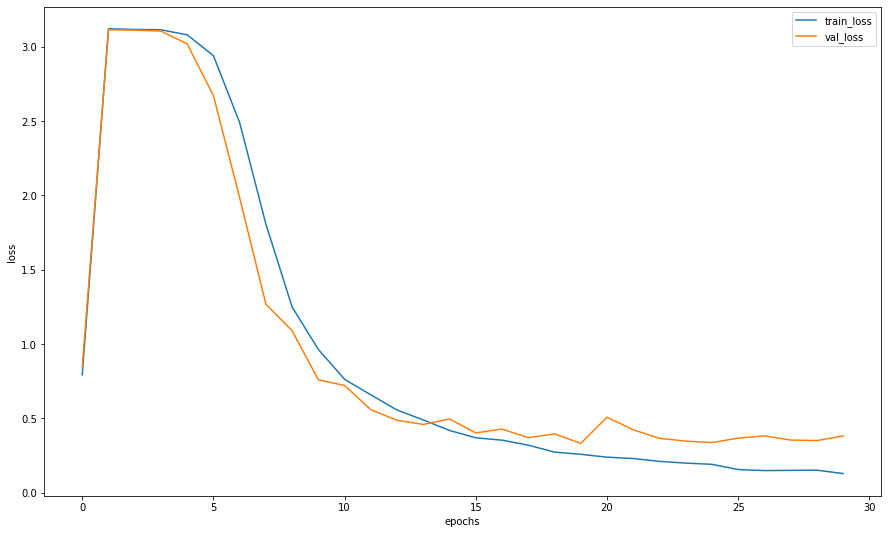

In [42]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# за 30 эпох сеть не доучилась, поэтому сохраним веса и прогоним еще 5 раз

In [55]:
torch.save(model_resnet.state_dict(), 'ResNet18_30_epoch.pth')

In [57]:
model_resnet.load_state_dict(torch.load('ResNet18_30_epoch.pth'))

<All keys matched successfully>

In [ ]:
model_resnet.eval()

In [61]:
history = train(train_dataset, val_dataset, model=model_resnet, epochs=5, batch_size=128)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.1357836555721608


epoch:  20%|██        | 1/5 [03:47<15:08, 227.11s/it]


Epoch 001 train_loss: 0.1358     val_loss 0.3564 train_acc 0.9603 val_acc 0.9320
loss 0.1352799569091506


epoch:  40%|████      | 2/5 [07:31<11:19, 226.42s/it]


Epoch 002 train_loss: 0.1353     val_loss 0.3952 train_acc 0.9612 val_acc 0.9228
loss 0.12443261273517085


epoch:  60%|██████    | 3/5 [11:15<07:30, 225.46s/it]


Epoch 003 train_loss: 0.1244     val_loss 0.4292 train_acc 0.9635 val_acc 0.9171
loss 0.1270153068375744


epoch:  80%|████████  | 4/5 [14:57<03:44, 224.68s/it]


Epoch 004 train_loss: 0.1270     val_loss 0.3743 train_acc 0.9647 val_acc 0.9270
loss 0.1031753073482462


epoch: 100%|██████████| 5/5 [18:40<00:00, 224.16s/it]


Epoch 005 train_loss: 0.1032     val_loss 0.3681 train_acc 0.9695 val_acc 0.9312


In [ ]:
# score на kaggle - 0.97555

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [62]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [63]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))

In [64]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet, imgs)

In [65]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [66]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]


Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [67]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

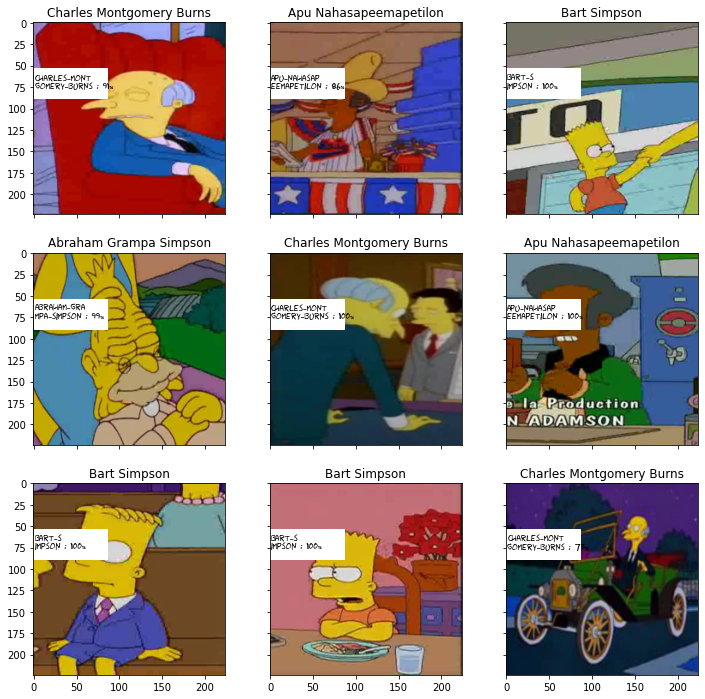

In [108]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [68]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [69]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('drive/My Drive/simpsons_resnet18_35e.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
